CarND-Advanced-Lane-Lines
==
Project : Advanced-Lane-Lines

step:
- Calibration of camera instrinsic and compensate a distortion
- Estimate transform matrix by stright road image
- Define the sobel threshold function and color threshold function
- Use a threshold function and Transform matrix
- Find lane pixel and estimate polynomial fits (left, right)
- Estimate lane curvature and offset of lane center
- Draw the lane fits, area and curvature text values

check:
- test by images
- test by videos

Camera Calibration with OpenCV
===

In [40]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle

In [81]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None 
        self.best_fit_flag = False 
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [41]:
def camera_calibration(images):
    # prepare object points.
    nx = 9 # number of corner on X Axis
    ny = 6 # number of corner on Y axis

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):

        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        out_fname = 'output_images\corners_'+fname.split('\\')[1]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # save the corners image
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imwrite(out_fname, img)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    return  mtx, dist

In [42]:
def cal_undistort(images, mtx, dist):
    # make a undistored image
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        undist = cv2.undistort(img,mtx,dist,None, mtx)
        # save the undistored image
        out_fname = 'output_images\\corners_'+fname.split('\\')[1]
        cv2.imwrite(out_fname, undist)

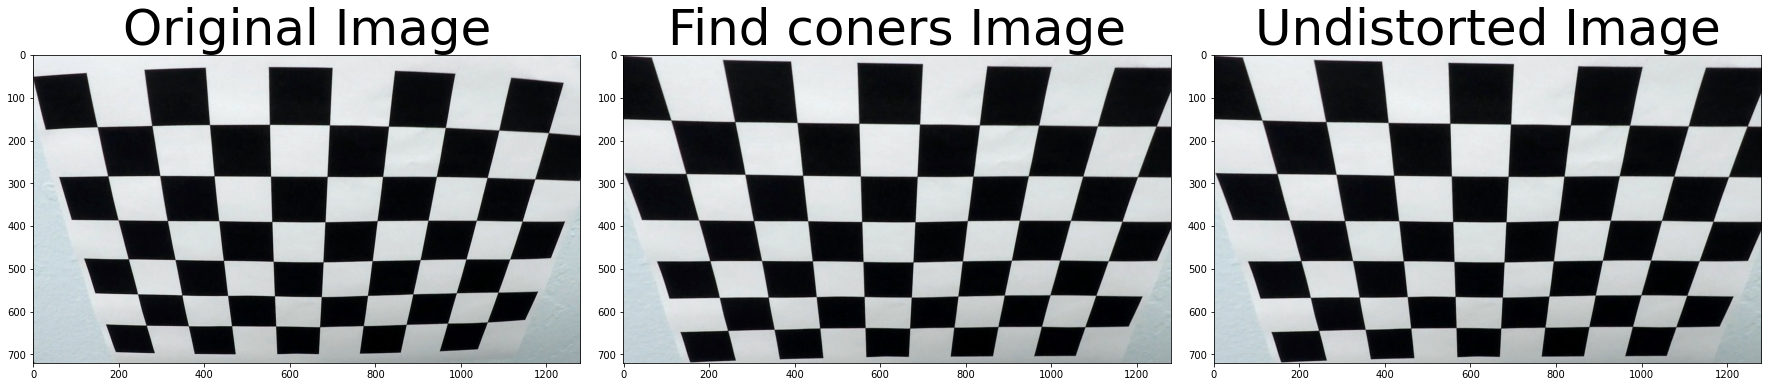

In [43]:
# selection calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# calibration images
mtx, dist = camera_calibration(images)

# save camera calibration parameter for later
with open('camera_parameter.p', 'wb') as file:
    pickle.dump(mtx, file)
    pickle.dump(dist, file)

# undistore images
cal_undistort(images, mtx, dist)

# result image check
check_img = 'calibration2.jpg'
img = cv2.imread('camera_cal\\'+check_img)
corner_img = cv2.imread('output_images\\corners_'+check_img)
undistorted = cv2.imread('output_images\\undistored_'+check_img)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(corner_img)
ax2.set_title('Find coners Image', fontsize=50)
ax3.imshow(undistorted)
ax3.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

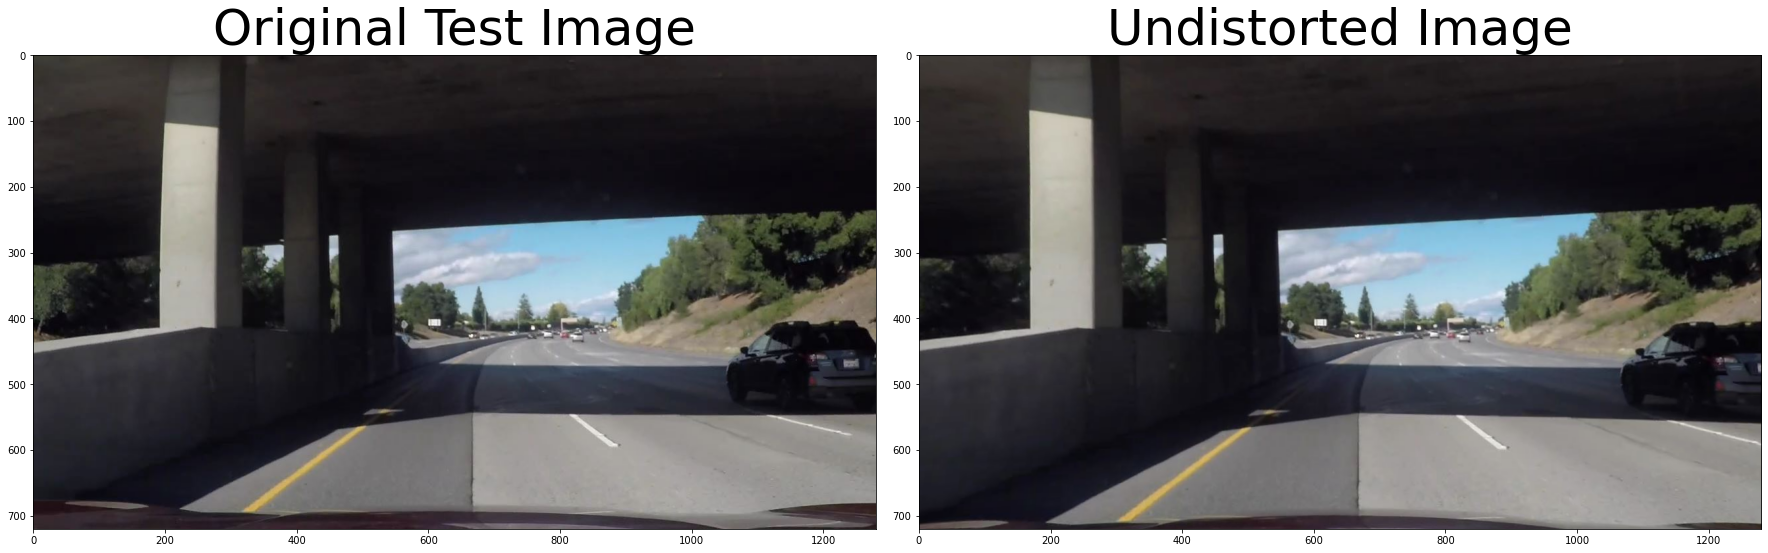

In [44]:
# Test image check
test_img = cv2.imread("test_images\challenge_video3.jpg")
test_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
# undistore images
undist = cv2.undistort(test_img,mtx,dist,None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Test Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Find Transform M by Straight lane image
===

In [45]:
# Straight lane image
# img = cv2.imread("test_images\challenge_video3.jpg")
img = cv2.imread("test_images\straight_lines1.jpg")
# img = cv2.imread("test_images\\test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.GaussianBlur(img, (3, 3), 0)

# undistore images
undist = cv2.undistort(img,mtx,dist,None, mtx)

In [46]:
shape = img.shape

center_x = img.shape[1] / 2
x_bottom_offset = 200
x_top_offset = 70
x_margin = 250

center_y = img.shape[0] / 2
y_bottom_offset = 50
y_top_offset = 100
y_margin = 50

left_bottom = [(x_bottom_offset),(shape[0] - y_bottom_offset)]
right_bottom = [(img.shape[1]-x_bottom_offset),(shape[0] - y_bottom_offset)]
right_top = [(center_x + x_top_offset),(center_y + y_top_offset)]
left_top = [(center_x - x_top_offset),(center_y + y_top_offset)]

src = np.float32([left_bottom, right_bottom, right_top, left_top])
dst = np.float32([[x_margin, img.shape[0]],[img.shape[1]-x_margin, img.shape[0]], [img.shape[1]-x_margin, y_margin], [x_margin, y_margin]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist, M, (shape[1],shape[0]), flags=cv2.INTER_AREA)

True

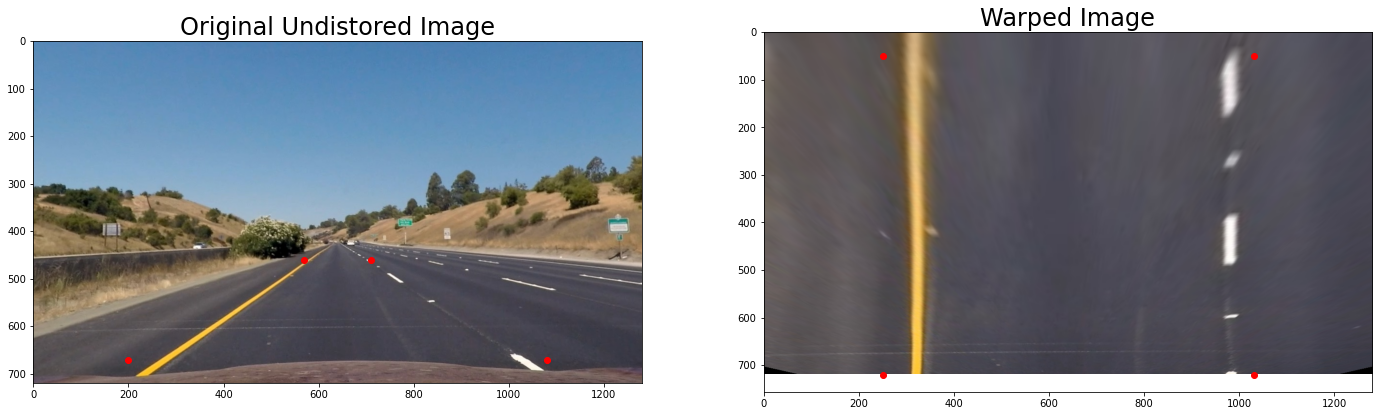

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(undist)
for p in src:
    ax1.plot(p[0], p[1], "ro")
ax1.set_title("Original Undistored Image", fontsize=24)
ax2.imshow(warped)
for p in dst:
    ax2.plot(p[0], p[1], "ro")
ax2.set_title("Warped Image", fontsize=24)

undist2 = cv2.cvtColor(undist, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images\\unwarped_image.jpg', undist2)
warped2 = cv2.cvtColor(warped, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images\\warped_image.jpg', warped2)

Define the sobel threshold function and color threshold function
===

In [48]:
def color_threshold(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [49]:
# Define a function that applies Sobel x or y, 
def abs_sobel_threshold(img, orient='x', thresh_min=0, thresh_max=255):
    # 1) Convert to grayscale or HLS' S-channel
    # Trans_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    Trans_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    Trans_img = Trans_img[:,:,2]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(Trans_img, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(Trans_img, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel= np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [50]:
# Define a function that magnitude of the gradient
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale or HLS' S-channel
    Trans_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Trans_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # Trans_img = Trans_img[:,:,2]
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(Trans_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(Trans_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [51]:
# Define a function that direction of the gradient
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale or HLS' S-channel
    Trans_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Trans_img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS);
    # Trans_img = Trans_img[:,:,2]
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(Trans_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(Trans_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direc = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direc)
    binary_output[(direc >= thresh[0]) & (direc <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

In [70]:
# Edit this function to create your own pipeline.
def soble_threshold(img):

    # Sobel threshold
    soble_x_binary = abs_sobel_threshold(img, orient='x', thresh_min=30, thresh_max=255)
    soble_y_binary = abs_sobel_threshold(img, orient='y', thresh_min=50, thresh_max=255)
    soble_mag = mag_threshold(img, sobel_kernel=3, mag_thresh=(80, 255))
    sobel_dir = dir_threshold(img, sobel_kernel=3, thresh=(0.6, 1.3))
    
    # Combine the thresholds
    combined = np.zeros_like(soble_x_binary)
    # combined[((soble_x_binary == 1) & (soble_y_binary == 1)) | ((sobel_dir == 1))] = 1
    combined[((soble_x_binary == 1) & (soble_y_binary == 1)) | (soble_mag == 1) & (sobel_dir == 1)] = 1

    # combined = soble_x_binary

    return combined

In [71]:
def transform(img):
    shape = img.shape
    warped = cv2.warpPerspective(img, M, (shape[1],shape[0]),flags=cv2.INTER_AREA)

    return warped

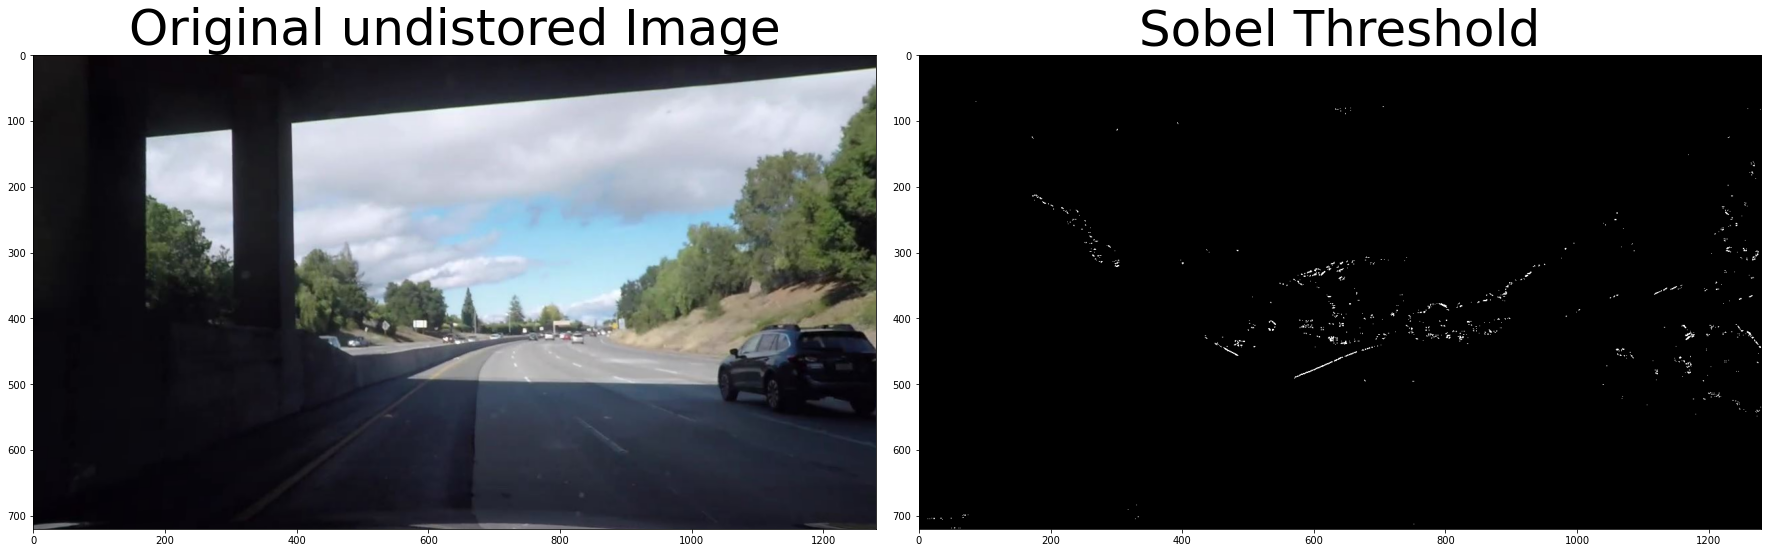

In [72]:
# Check by test image
img = cv2.imread("test_images\\challenge_video5.jpg")
# img = cv2.imread("test_images\project_video3.jpg")
# img = cv2.imread("test_images\\test4.jpg")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# undistore images
undist = cv2.undistort(img,mtx,dist,None, mtx)

sobel_binary = soble_threshold(undist)
color_binary = color_threshold(undist, thresh=(150, 255))
combined_binary = np.zeros_like(sobel_binary)
combined_binary[(sobel_binary == 1) | (color_binary == 1)] = 1

# cv2.imwrite('output_images\\sobel_binary.jpg', sobel_binary2)
# cv2.imwrite('output_images\\color_binary.jpg', color_binary)
# cv2.imwrite('output_images\\combined_binary.jpg', combined_binary)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original undistored Image', fontsize=50)
ax2.imshow(sobel_binary, cmap='gray')
ax2.set_title('Sobel Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

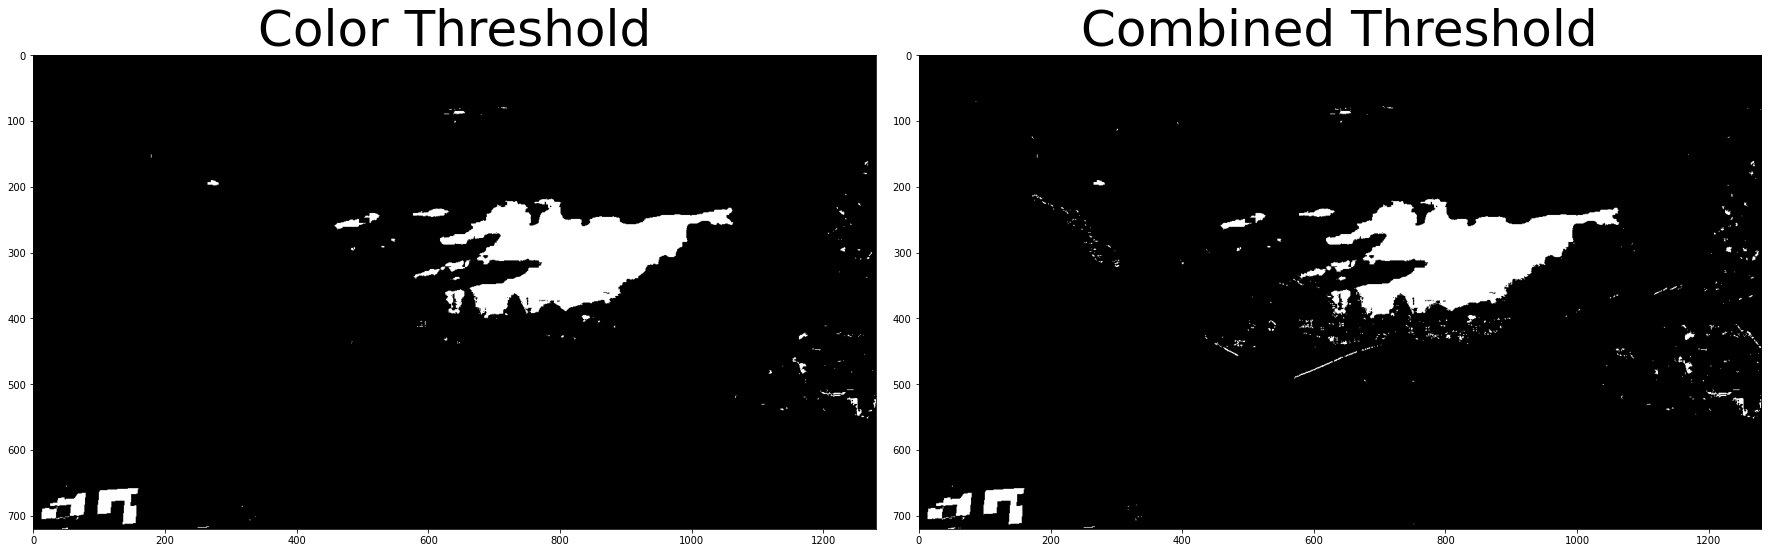

In [73]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary, cmap='gray')
ax1.set_title('Color Threshold', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

7571 405


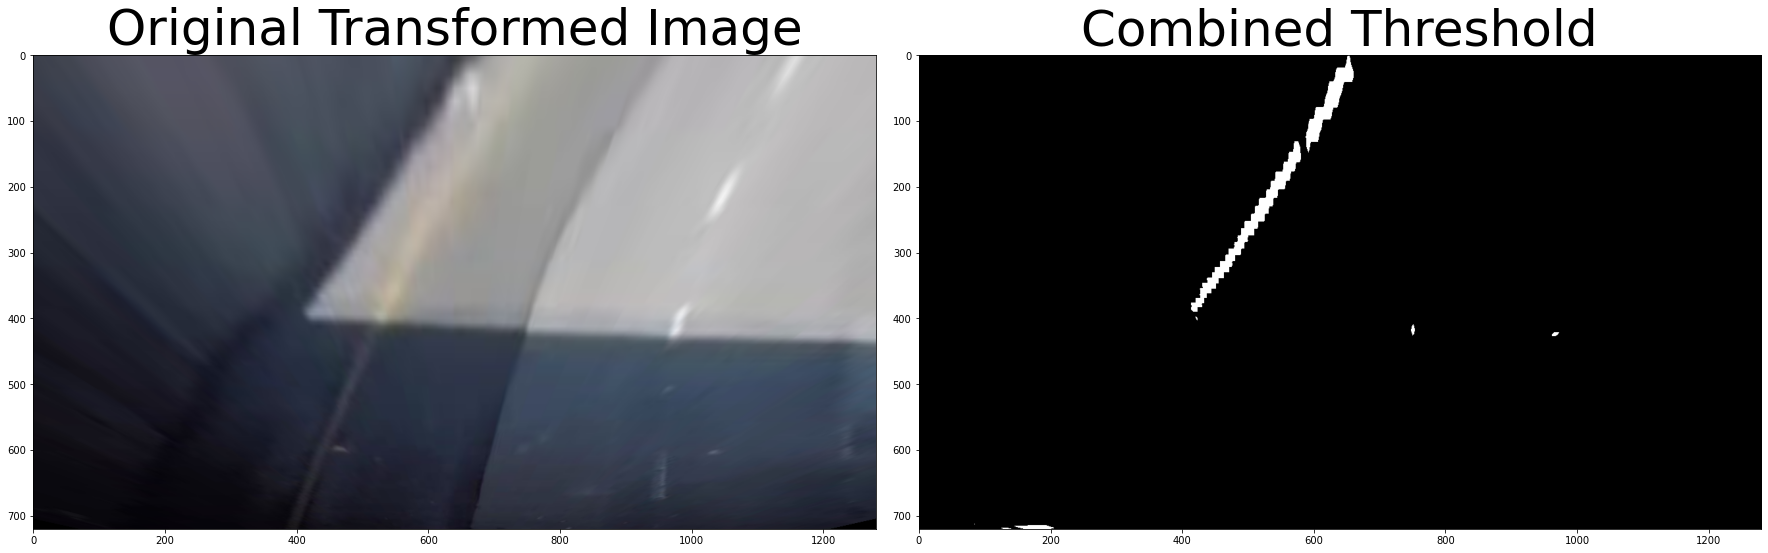

In [74]:
warped = transform(undist)
warped_binary = transform(combined_binary)

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_binary)

print(len(leftx),len(rightx))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Original Transformed Image', fontsize=50)
ax2.imshow(warped_binary, cmap='gray')
ax2.set_title('Combined Threshold', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [75]:
def hist(img):
    # Lane lines are likely to be mostly vertical nearest to the car
    # bottom_half = img[img.shape[0]//4:(img.shape[0]//4)*3:,:]
    bottom_half = img[img.shape[0]//2::,:]
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half,axis=0)
    return histogram

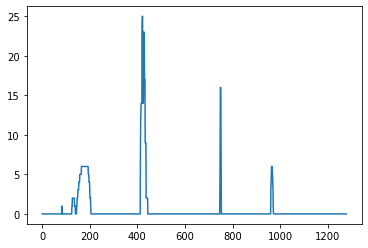

In [76]:
# Create histogram of image binary activations
histogram = hist(warped_binary)
# Visualize the resulting histogram
plt.plot(histogram)

Find lane pixel and estimate polynomial fits
===

In [82]:
def find_lane_pixels(binary_warped, left_line, right_line):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        if leftx_current > margin :
            win_xleft_low = leftx_current - margin  # Update this
        else:
            win_xleft_low = 0
        win_xleft_high = leftx_current + margin  # Update this

        win_xright_low = rightx_current - margin  # Update this
        if (rightx_current+margin) > binary_warped.shape[1]:
            win_xright_high = binary_warped.shape[1]
        else:
            win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        # (win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),
        # (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) >minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    # leftx = nonzerox[left_lane_inds]
    # lefty = nonzeroy[left_lane_inds] 
    # rightx = nonzerox[right_lane_inds]
    # righty = nonzeroy[right_lane_inds]
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]

    # return leftx, lefty, rightx, righty, out_img
    return left_line, right_line, out_img

In [79]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    lleft_line, right_line, out_img = find_lane_pixels(binary_warped, left_line, right_line)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    # left_fit = np.polyfit(left_line.ally,left_line.allx,2)
    # right_fit = np.polyfit(right_line.ally,right_line.allx,2)

    left_line.current_fit = np.polyfit(left_line.ally,left_line.allx,2)
    right_line.current_fit = np.polyfit(right_line.ally,right_line.allx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit

In [80]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [62]:
def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
                    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, out_img

In [63]:
def find_lane_pixels_slid(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
                    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return leftx, lefty, rightx, righty, out_img

Estimate lane curvature and offset of lane center
===

In [64]:
def measure_offset(y_eval, ym_per_pix, xm_per_pix, left_fit_cr, right_fit_cr, shape_x):

    left_pt = left_fit_cr[0] * (y_eval*ym_per_pix)**2 + \
              left_fit_cr[1] * (y_eval*ym_per_pix) + left_fit_cr[2] 
    right_pt = right_fit_cr[0] * (y_eval*ym_per_pix)**2 + \
               right_fit_cr[1] * (y_eval*ym_per_pix) + right_fit_cr[2] 

    midlane_pt = (left_pt + right_pt)/2
    midcam_pt = (shape_x/2)*xm_per_pix
    offset_x =  midlane_pt - midcam_pt
    return offset_x

In [66]:
def measure_curvature_real(leftx, rightx, shape):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, shape[0] - 1, shape[0] )
    y_eval = np.max(ploty)

    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_fit_cr_dot = 2*left_fit_cr[0]*(30) + left_fit_cr[1]
    left_fit_cr_2dot = 2*left_fit_cr[0]
    left_curve = (1 + left_fit_cr_dot**2)**(3/2) / np.abs(left_fit_cr_2dot)
    
    right_fit_cr_dot = 2*right_fit_cr[0]*(30) + right_fit_cr[1]
    right_fit_cr_2dot = 2*right_fit_cr[0]
    right_curve = (1 + right_fit_cr_dot**2)**(3/2) / np.abs(right_fit_cr_2dot)
    
    offset_x = measure_offset(y_eval, ym_per_pix, xm_per_pix, left_fit_cr, right_fit_cr, shape[1])

    return left_curve, right_curve, offset_x

Draw the lane fits, area and curvature text values
===

In [67]:
def draw_line(warped_binary, undist, ploty, left_fitx, right_fitx, left_curve, right_curve, offset_x):

    shape = undist.shape
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (shape[1], shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # plt.imshow(result)

    return result

In [68]:
def draw_text(img, curve, offset_x):

    new_img = np.copy(img)

    font = cv2.FONT_HERSHEY_SIMPLEX
    curve_text = 'Curve Radius: ' + '{:04.2f}'.format(curve) + 'm'
    cv2.putText(new_img, curve_text, (30,50), font, 1.5, (255,0,0), 2, cv2.LINE_AA)
    if offset_x < 0 :
        offset_text = 'Offset[Right]: ' + '{:04.2f}'.format(np.abs(offset_x)) + 'm'
    else:
        offset_text = 'Offset[Left]: ' + '{:04.2f}'.format(np.abs(offset_x)) + 'm'
    cv2.putText(new_img, offset_text, (30,100), font, 1.5, (255,0,0), 2, cv2.LINE_AA)

    return new_img

Pipeline : Find Lane Lines
===

In [69]:
def process_image(img):
    # make undistored image
    undist = cv2.undistort(img,mtx,dist,None, mtx)
    
    # make transformed image 
    shape = img.shape
    warped = cv2.warpPerspective(undist, M, (shape[1],shape[0]), flags=cv2.INTER_AREA) 

    # Image filtering by Sobel & Color gradient
    sobel_binary = soble_threshold(undist)
    color_binary = color_threshold(undist, thresh=(150, 255))
    # combine filtered image
    combined_binary =  np.zeros_like(sobel_binary)
    combined_binary[(sobel_binary == 1) | (color_binary == 1)] = 1
    warped_binary = cv2.warpPerspective(combined_binary, M, (shape[1],shape[0]), flags=cv2.INTER_AREA) 

    ploty = np.linspace(0, shape[0] - 1, shape[0] )

    # first time and fail to continous detect
    if (left_line.detected == False) or (right_line.detected == False):
        # left_line.allx, left_line.ally, rightx, righty, out_img = find_lane_pixels(warped_binary)
        left_line, right_line, out_img = find_lane_pixels(warped_binary, left_line, right_line)

    # find by sliding
    else:
        left_line.recent_xfitted = left_line.current_fit
        right_line.recent_xfitted = right_line.current_fit
        left_line.allx, left_line.ally, rightx, righty, out_img = find_lane_pixels_slid(warped_binary,left_line.current_fit,right_line.current_fit)

    detect_minpt = 1500
    if(len(leftx) > detect_minpt):
        left_line.allx = leftx
        left_line.ally = lefty
        left_line.detected = True
    else:
        leftx = left_line.allx
        lefty = left_line.ally
        left_line.detected = False

    if(len(rightx) > detect_minpt):
        right_line.allx = rightx
        right_line.ally = righty
        right_line.detected = True
    else:
        rightx = right_line.allx
        righty = right_line.ally
        right_line.detected = False

    

    # left_line.current_fit = np.polyfit(lefty, leftx, 2)
    # right_line.current_fit = np.polyfit(righty, rightx, 2)

    if(left_line.detected == True) and (right_line.detected == True):
        left_line.current_fit = np.polyfit(lefty, leftx, 2)
        right_line.current_fit = np.polyfit(righty, rightx, 2)

        if (left_line.best_fit_flag == True) and (right_line.best_fit_flag == True):
            # difference in fit coefficients between last and new fits
            left_line.diffs = left_line.best_fit - left_line.current_fit
            right_line.diffs = right_line.best_fit - right_line.current_fit
        else:
            left_line.best_fit = left_line.current_fit
            right_line.best_fit = right_line.current_fit
            left_line.best_fit_Flag = True
            right_line.best_fit_Flag = True
            left_line.diffs = np.array([0,0,0], dtype='float')
            right_line.diffs = np.array([0,0,0], dtype='float')

        # update best fit
        if (np.abs(left_line.diffs[0]) < 0.5) and (np.abs(left_line.diffs[1]) < 1) and (np.abs(left_line.diffs[2]) < 50):
            left_line.best_fit[0] = (left_line.best_fit[0] + left_line.current_fit[0])/2
            left_line.best_fit[1] = (left_line.best_fit[1] + left_line.current_fit[1])/2
            left_line.best_fit[2] = (left_line.best_fit[2] + left_line.current_fit[2])/2
        else:
            left_line.detected = False
        if (np.abs(right_line.diffs[0]) < 0.1) and (np.abs(right_line.diffs[1]) < 0.1) and (np.abs(right_line.diffs[2]) < 0.1):
            right_line.best_fit[0] = (right_line.best_fit[0] + right_line.current_fit[0])/2
            right_line.best_fit[1] = (right_line.best_fit[1] + right_line.current_fit[1])/2
            right_line.best_fit[2] = (right_line.best_fit[2] + right_line.current_fit[2])/2
        else:
            right_line.detected = False

    else:
        left_line.best_fit = left_line.current_fit
        right_line.best_fit = right_line.current_fit

    # calibrate best fit data
    left_line.bestx  = left_line.best_fit[0]*ploty**2  + left_line.best_fit[1]*ploty  + left_line.best_fit[2]
    right_line.bestx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]

    # Measre curvature
    left_curve, right_curve, offset_x = measure_curvature_real(left_line.bestx, right_line.bestx, shape)

    # averaging left and right curve
    curve = (left_curve + right_curve) /2

    # warped_binary = cv2.addWeighted(warped_binary, 1, out_img, 0.3, 0)

    # draw curvature, lane area, 
    result = draw_line(warped_binary, undist, ploty, left_line.bestx, right_line.bestx, left_curve, right_curve, offset_x)

    # Add curvature text data
    result = draw_text(result, curve, offset_x)

    return result

Check Pipeline
===
- Image
- video

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
# Test for image
# img = cv2.imread("test_images\\test4.jpg")
# img = cv2.imread("test_images\project_video2.jpg")
img = cv2.imread("test_images\challenge_video4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

left_line = Line()
right_line = Line()
result = process_image(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('After Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

result2 = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images\\result_image.jpg', result2)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

In [34]:
# test for video(stream image)
project_video_out = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")

left_line = Line()
right_line = Line()
project_video = clip1.fl_image(process_image)

%time project_video.write_videofile(project_video_out, audio=False)
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(clip1))

t:   0%|          | 2/1260 [00:00<01:39, 12.68it/s, now=None]Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4

Moviepy - Done !
Moviepy - video ready project_video_out.mp4
Wall time: 3min 19s


In [120]:
# test for video2(stream image)
project_video_out = 'challenge_video_out.mp4'
clip = VideoFileClip("challenge_video.mp4")

left_line = Line()
right_line = Line()
project_video = clip.fl_image(process_image)

%time project_video.write_videofile(project_video_out, audio=False)

t:   0%|          | 2/485 [00:00<00:37, 12.80it/s, now=None]Moviepy - Building video challenge_video_out.mp4.
Moviepy - Writing video challenge_video_out.mp4

Moviepy - Done !
Moviepy - video ready challenge_video_out.mp4
Wall time: 1min 15s
